## Principle Component Analysis
- A data transformation technique converts high-dimensional data to lower-dimensional representation
- The idea is to removed unneccessary information/ features which includes the noise from the input so the model can learn more useful information from important features
- It helps to find another basis or `principle components` to help classify the data better. It is similar to changing the perspective to look at the feature space at a different angle and find the best angle to observe all the variance/ spread in the data
- Data needs to be scaled for PCA to work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We start off by building a 3-D toy dataset, then uses PCA to transform it into 2D dataset

In [2]:
# build the 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

In [4]:
pca.components_.T

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

Let us plot the 3D dataset and the 2D transformation

(-1.0, 1.0)

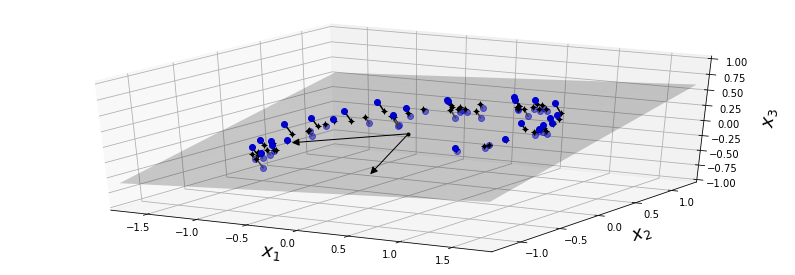

In [5]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 4.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


And this is the projection of the 2D data onto the two new axises Z1 and Z2. As you can see, Z1 and Z2 are the new basis that best describe the variance/ spread of our toy data. The use of z1 and z2 as input to the ML model would be much better and useful than the original axises.

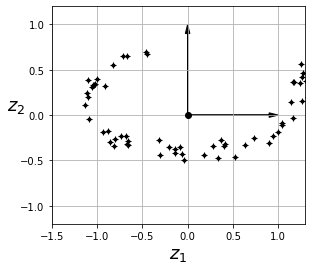

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
final_train = pd.read_csv('data/final_titanic_train.csv')

# create X (features) and y (response)
X = final_train.loc[:, ~final_train.columns.isin(['Survived'])]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

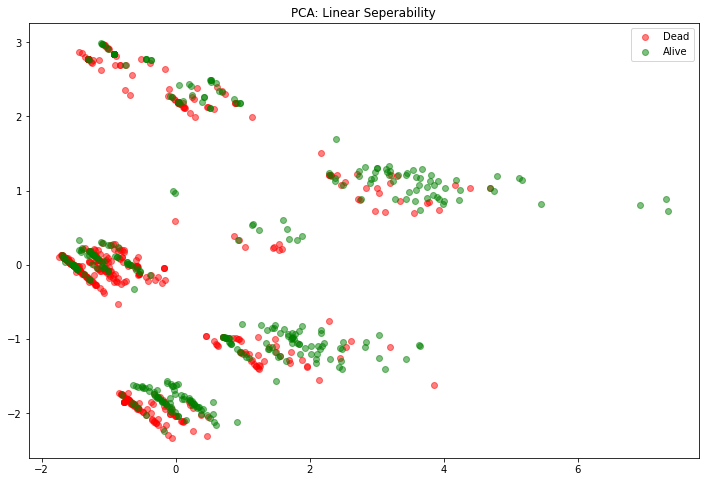

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_pca1 = X.copy()
X_pca1 = StandardScaler().fit_transform(X_pca1)

#instantiate PCA
pca = PCA(n_components = 2)
X_redu1 = pca.fit_transform(X_pca1)

died1 = X_redu1[y == 0]
live1 = X_redu1[y == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
plt.scatter(died1[:,0].reshape(1,-1), died1[:,1].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
plt.scatter(live1[:,0].reshape(1,-1), live1[:,1].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])

plt.show()

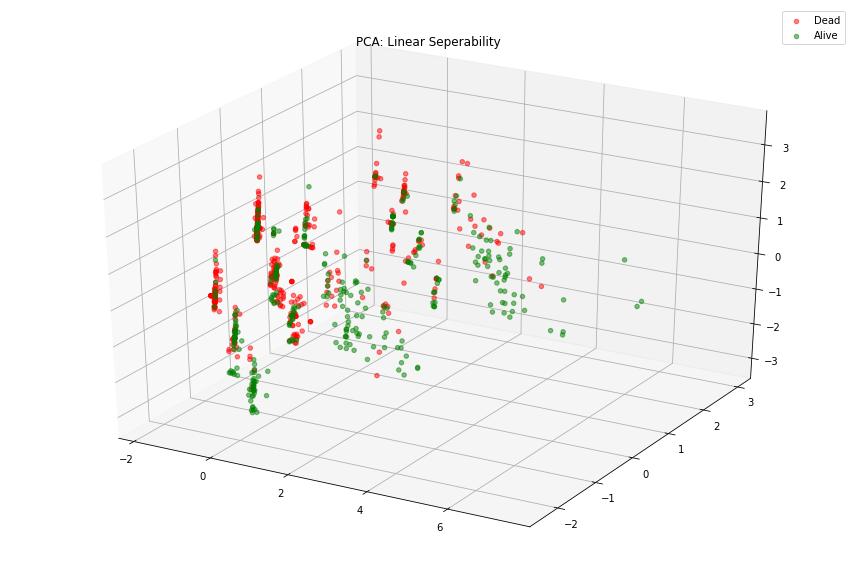

In [9]:
#Scaling down Data
X_pca2 = X.copy()
X_pca2 = StandardScaler().fit_transform(X_pca2)

#instantiate PCA
pca = PCA(n_components = 3)
X_redu2 = pca.fit_transform(X_pca2)

died = X_redu2[y == 0]
live = X_redu2[y == 1]
comp =[0,1]

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d', )
ax.scatter(died[:,0].reshape(1,-1), died[:,1].reshape(1,-1),died[:,2].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
ax.scatter(live[:,0].reshape(1,-1), live[:,1].reshape(1,-1),live[:,2].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])
plt.tight_layout()

plt.show()

In [10]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

X_pca2 = X_train.copy()
X_pca2 = StandardScaler().fit_transform(X_pca2)

#instantiate PCA, varying the number of components we want to use can enhance the model's performance
pca = PCA(n_components = 5)
X_redu2 = pca.fit_transform(X_pca2)

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=1)) 
])

poly_kernel_svm_clf.fit(X_redu2, y_train)
poly_kernel_svm_clf.score(X_redu2, y_train)

0.8342696629213483

By using PCA to find the top 5 components that we can best describe our Titanic dataset, we can improve our previous SVM model to 83% accuracy. 